# Image Classification Model - MONAI

In [1]:
import torch
import monai
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    LoadImaged,
    RandSpatialCrop,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.networks.nets import DenseNet
from monai.networks.blocks import Convolution
from monai.losses import DiceLoss
from monai.metrics import ROCAUCMetric
from monai.data import CacheDataset, DataLoader, Dataset, ImageReader, MetaTensor
from monai.inferers import sliding_window_inference
from monai.transforms import Activations, AsDiscrete, KeepLargestConnectedComponent
from monai.visualize import plot_2d_or_3d_image
monai.utils.set_determinism(17)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import os

from skimage.io import imread, imsave, imshow

from tqdm import tqdm

import datetime
import numpy as np

##### Hyperparameters

In [2]:
batch_size = 4
num_workers = 4
learning_rate = 5e-6
num_epochs = 15
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


##### Dataset Creation

In [3]:
def class_encoding(label):
    label_to_index = {
        'PDAC' : 0,
        'Melanoma' : 1,
        'CTCL' : 2,
        'Basal Cell' : 3
    }
    
    return torch.tensor(torch.nn.functional.one_hot(torch.tensor(label_to_index[label]), 4))
    
def class_decoding(index):
    index_to_label = {
        0 : 'PDAC',
        1 : 'Melanoma',
        2 : 'CTCL',
        3 : 'Basal Cell'
    }
    
    return index_to_label[torch.argmax(index).item()]
    
class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, mode='train'):
        self.data_dir = os.path.join(data_dir, mode)
        self.class_dirs = os.listdir(self.data_dir)
        self.n_classes = len(self.class_dirs)
        self.image_files = []
        self.labels = []
        for label in self.class_dirs:
            temp_path = os.path.join(self.data_dir, label)
            image_paths = os.listdir(temp_path)
            self.labels.extend([class_encoding(label)]*len(image_paths))
            for image_path in image_paths:
                self.image_files.append(torch.tensor(imread(os.path.join(temp_path, image_path))))

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        image = self.image_files[index].unsqueeze(0).to(torch.float32)
        label = self.labels[index].to(torch.float32)
        return image, label

In [4]:
DATA_DIR = '../data/classification_dataset/'
train_dataset = ClassificationDataset(DATA_DIR, mode='train')
val_dataset = ClassificationDataset(DATA_DIR, mode='val')
test_dataset = ClassificationDataset(DATA_DIR, mode='test')

C:\Users\gopik\AppData\Local\Temp\ipykernel_28024\1041114759.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.nn.functional.one_hot(torch.tensor(label_to_index[label]), 4))


In [5]:
train_dataset.__len__(), val_dataset.__len__(), test_dataset.__len__()

(128, 16, 16)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_dataset, batch_size=4, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=4, pin_memory=torch.cuda.is_available())

In [7]:
len(train_loader), len(val_loader), len(test_loader)

(32, 4, 4)

##### Model Definition - DenseNet

In [8]:
in_channels = 1
out_channels = 4
model = DenseNet(
    spatial_dims=2, 
    in_channels=in_channels, 
    out_channels=out_channels, 
    init_features=64, 
    growth_rate=32, 
    block_config=(6, 12, 24, 16), 
).to(device)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm

##### Loss Function and Optimizer

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

##### Training and Validation Loop

In [10]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # Compute the loss
        loss = criterion(outputs, masks)
        # Backward pass and optimization
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, masks)

            test_loss += loss.item()

        test_loss /= len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

  7%|▋         | 1/15 [00:09<02:19,  9.97s/it]

Epoch 1/15, Train Loss: 0.3480, Test Loss: 0.3390


 13%|█▎        | 2/15 [00:13<01:20,  6.18s/it]

Epoch 2/15, Train Loss: 0.3365, Test Loss: 0.3288


 20%|██        | 3/15 [00:17<01:00,  5.03s/it]

Epoch 3/15, Train Loss: 0.3285, Test Loss: 0.3221


 27%|██▋       | 4/15 [00:20<00:49,  4.47s/it]

Epoch 4/15, Train Loss: 0.3155, Test Loss: 0.3130


 33%|███▎      | 5/15 [00:24<00:41,  4.14s/it]

Epoch 5/15, Train Loss: 0.3119, Test Loss: 0.3073


 40%|████      | 6/15 [00:27<00:35,  3.95s/it]

Epoch 6/15, Train Loss: 0.3032, Test Loss: 0.3022


 47%|████▋     | 7/15 [00:31<00:30,  3.82s/it]

Epoch 7/15, Train Loss: 0.3011, Test Loss: 0.2982


 53%|█████▎    | 8/15 [00:35<00:26,  3.75s/it]

Epoch 8/15, Train Loss: 0.2934, Test Loss: 0.2949


 60%|██████    | 9/15 [00:38<00:22,  3.70s/it]

Epoch 9/15, Train Loss: 0.2884, Test Loss: 0.2924


 67%|██████▋   | 10/15 [00:42<00:18,  3.71s/it]

Epoch 10/15, Train Loss: 0.2832, Test Loss: 0.2885


 73%|███████▎  | 11/15 [00:45<00:14,  3.68s/it]

Epoch 11/15, Train Loss: 0.2685, Test Loss: 0.2884


 80%|████████  | 12/15 [00:49<00:11,  3.67s/it]

Epoch 12/15, Train Loss: 0.2756, Test Loss: 0.2865


 87%|████████▋ | 13/15 [00:53<00:07,  3.66s/it]

Epoch 13/15, Train Loss: 0.2757, Test Loss: 0.2842


 93%|█████████▎| 14/15 [00:56<00:03,  3.64s/it]

Epoch 14/15, Train Loss: 0.2730, Test Loss: 0.2813


100%|██████████| 15/15 [01:00<00:00,  4.04s/it]

Epoch 15/15, Train Loss: 0.2643, Test Loss: 0.2816


In [11]:
# Save the trained model
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_name = f"classification_model_monai_densenet_{timestamp}.pth"
save_path = f"../models/classification_model/{model_name}"
torch.save(model.state_dict(), save_path)

##### Testing

In [50]:
model.eval()
correct_predictions = 0
total = 0
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = Activations(softmax=True, dim=1)(model(images))
        predicted = torch.argmax(outputs, dim=1)
        correct_predictions += (predicted == torch.argmax(masks, dim=1)).sum().item()
        total += masks.size(0)
accuracy = 100 * correct_predictions / total
print(f"Accuracy: {accuracy}%")

Accuracy: 37.5%


##### Visualization

In [53]:
image, label = test_dataset.__getitem__(15)

c:\Users\gopik\anaconda3\envs\programming\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


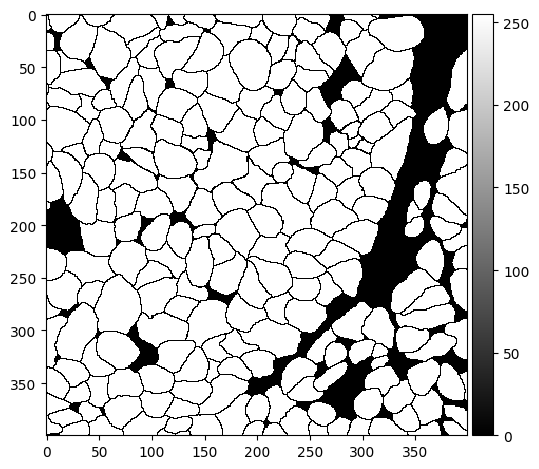

In [54]:
imshow(image.squeeze().numpy(), cmap="gray")

In [55]:
sam_output = model(image.unsqueeze(0).to(device))

In [56]:
class_decoding(torch.argmax(Activations(softmax=True, dim=1)(sam_output)).clone().detach())

'PDAC'

In [57]:
class_decoding(label)

'PDAC'